In [9]:
from matplotlib import font_manager as mfonts
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


def _crs_coord_project(crs_target, xcoords, ycoords, crs_source):
    """ metric coordinates (x, y) from cartopy.crs_source"""
    
    axes_coords = crs_target.transform_points(crs_source, xcoords, ycoords)
    
    return axes_coords


def _add_bbox(ax, list_of_patches, paddings={}, bbox_kwargs={}):
    
    '''
    Description:
        This helper function adds a box behind the scalebar:
            Code inspired by: https://stackoverflow.com/questions/17086847/box-around-text-in-matplotlib
    '''
    
    zorder = list_of_patches[0].get_zorder() - 1
    
    xmin = min([t.get_window_extent().xmin for t in list_of_patches])
    xmax = max([t.get_window_extent().xmax for t in list_of_patches])
    ymin = min([t.get_window_extent().ymin for t in list_of_patches])
    ymax = max([t.get_window_extent().ymax for t in list_of_patches])
    

    xmin, ymin = ax.transData.inverted().transform((xmin, ymin))
    xmax, ymax = ax.transData.inverted().transform((xmax, ymax))

    
    xmin = xmin - ( (xmax-xmin) * paddings['xmin'])
    ymin = ymin - ( (ymax-ymin) * paddings['ymin'])
    
    xmax = xmax + ( (xmax-xmin) * paddings['xmax'])
    ymax = ymax + ( (ymax-ymin) * paddings['ymax'])
    
    width = (xmax-xmin)
    height = (ymax-ymin)

    rect = patches.Rectangle((xmin,ymin),
                              width,
                              height, 
                              facecolor=bbox_kwargs['facecolor'], 
                              edgecolor =bbox_kwargs['edgecolor'],
                              alpha=bbox_kwargs['alpha'], 
                              transform=ax.projection,
                              fill=True,
                              clip_on=False,
                              zorder=zorder)

    ax.add_patch(rect)
    return ax

def add_scalebar(ax, metric_distance=100, 
                 at_x=(0.1, 0.4), 
                 at_y=(0.05, 0.075), 
                 max_stripes=5,
                 ytick_label_margins = 0.25,
                 fontsize= 8,
                 font_weight='bold',
                 rotation = 45,
                 zorder=999,
                 paddings = {'xmin':0.3,
                             'xmax':0.3,
                             'ymin':0.3,
                             'ymax':0.3},
    
                 bbox_kwargs = {'facecolor':'w',
                                'edgecolor':'k',
                                'alpha':0.7}
                ):
    """
    Add a scalebar to a GeoAxes of type cartopy.crs.OSGB (only).

    Args:
    * at_x : (float, float)
        target axes X coordinates (0..1) of box (= left, right)
    * at_y : (float, float)
        axes Y coordinates (0..1) of box (= lower, upper)
    * max_stripes
        typical/maximum number of black+white regions
    """
    old_proj = ax.projection
    ax.projection = ccrs.PlateCarree()
    # Set a planar (metric) projection for the centroid of a given axes projection:
    # First get centroid lon and lat coordinates:
    
    lon_0, lon_1, lat_0, lat_1 = ax.get_extent(ax.projection.as_geodetic())
    
    central_lon = np.mean([lon_0, lon_1])
    central_lat = np.mean([lat_0, lat_1])
    
    # Second: set the planar (metric) projection centered in the centroid of the axes;
        # Centroid coordinates must be in lon/lat.
    proj=ccrs.EquidistantConic(central_longitude=central_lon, central_latitude=central_lat)
    
    # fetch axes coordinates in meters
    x0, x1, y0, y1 = ax.get_extent(proj)
    ymean = np.mean([y0, y1])
    
    # set target rectangle in-visible-area (aka 'Axes') coordinates
    axfrac_ini, axfrac_final = at_x
    ayfrac_ini, ayfrac_final = at_y
    
    # choose exact X points as sensible grid ticks with Axis 'ticker' helper
    xcoords = []
    ycoords = []
    xlabels = []
    for i in range(0 , 1+ max_stripes):
        dx = (metric_distance * i) + x0
        xlabels.append(dx - x0)
        
        xcoords.append(dx)
        ycoords.append(ymean)
    
    # Convertin to arrays:

    xcoords = np.asanyarray(xcoords)
    ycoords = np.asanyarray(ycoords)

    x_targets, y_targets, z_targets = _crs_coord_project(ax.projection, xcoords, ycoords, proj).T
    x_targets = [x + (axfrac_ini * (lon_1 - lon_0)) for x in  x_targets]
    
    transform = ax.projection
    
    # grab min+max for limits
    xl0, xl1 = x_targets[0], x_targets[-1]
    
    # calculate Axes Y coordinates of box top+bottom
    yl0, yl1 = [lat_0 + ay_frac * (lat_1 - lat_0) for ay_frac in [ayfrac_ini, ayfrac_final]]

    # calculate Axes Y distance of ticks + label margins
    y_margin = (yl1-yl0)*ytick_label_margins
    
    # fill black/white 'stripes' and draw their boundaries
    fill_colors = ['black', 'white']
    i_color = 0
    
    filled_boxs = []
    for xi0, xi1 in zip(x_targets[:-1],x_targets[1:]):
        # fill region
        filled_box = plt.fill(
                              (xi0, xi1, xi1, xi0, xi0), 
                              (yl0, yl0, yl1, yl1, yl0),
                 
                              fill_colors[i_color],
                              transform=transform,
                              clip_on=False,
                              zorder=zorder
                            )
        
        filled_boxs.append(filled_box[0])
        
        # draw boundary
        plt.plot((xi0, xi1, xi1, xi0, xi0), 
                 (yl0, yl0, yl1, yl1, yl0),
                 'black',
                 clip_on=False,
                transform=transform,
                zorder=zorder)
        
        i_color = 1 - i_color
    
    # adding boxes

    # Add bounding boxes around filled regions
    _add_bbox(ax, 
             filled_boxs,
             bbox_kwargs = bbox_kwargs ,
             paddings =paddings)

    # add short tick lines
    for x in x_targets:
        plt.plot((x, x), (yl0, yl0-y_margin), 'black', 
                 transform=transform,
                 zorder=zorder,
                 clip_on=False)
    # add a scale legend 'Km'
    font_props = mfonts.FontProperties(size=fontsize, 
                                       weight=font_weight)
    
    plt.text(
        0.5 * (xl0 + xl1),
        yl1 + y_margin,
        'km',
        color='k',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontproperties=font_props,
        transform=transform,
        clip_on=False,
        zorder=zorder)

    # add numeric labels
    for x, xlabel in zip(x_targets, xlabels):
        print('Label set in: ', x, yl0 - 2 * y_margin)
        plt.text(x,
                 yl0 - 2 * y_margin,
                 '{:g}'.format((xlabel) * 0.001),
                 verticalalignment='top',
                 horizontalalignment='center',
                 fontproperties=font_props,
                 transform=transform,
                 rotation=rotation,
                 clip_on=False,
                 zorder=zorder+1,
                #bbox=dict(facecolor='red', alpha=0.5) # this would add a box only around the xticks
                )
    
    
    # Adjusting figure borders to ensure that the scalebar is within its limits
    ax.projection = old_proj
    ax.get_figure().canvas.draw()
    # fig.tight_layout() 

In [10]:
# Set a global font size
mpl.rcParams.update({'font.size': 10})
steelblue = "#4682B4"  # Hex code for steelblue

def add_polygon_from_bna(filename, ax, color):
    with open(filename, 'r') as file:
        header = file.readline().split(',')
        polygon_name = header[0].strip('"')
        num_points = int(header[2])
        
        points = []
        for _ in range(num_points):
            line = file.readline()
            points.append(list(map(float, line.split(','))))
        
        polygon = patches.Polygon(points, fill=None, label=polygon_name, color=color)
        ax.add_patch(polygon)
        plt.legend()

# filter df_events
def firter_events_df(df, distance_threshold=0.5):
    # Extract coordinates
    coordinates = df[['Latitude (WGS84)', 'Longitude (WGS84)']].values
    # Convert degrees to radians for haversine
    radians_coords = np.radians(coordinates)
    # Build the BallTree
    tree = BallTree(radians_coords, metric='haversine')
    # Initialize the mask to keep track of which earthquakes to keep
    mask = np.ones(len(df), dtype=bool)
    distance_threshold_rad = distance_threshold / 6371.0  # Convert km to radians

    for i in range(len(coordinates)):
        if not mask[i]:
            continue
        # Query the BallTree for neighbors within the distance threshold
        neighbors = tree.query_radius([radians_coords[i]], r=distance_threshold_rad)[0]
        mask[neighbors] = False  # Mark all neighbors as too close
        mask[i] = True  # Keep the current event

    return df[mask]

def plot_earthquakes_comparison(original_df, filtered_df, LATS, LONS):

    # Split lons and lats
    lon1, lon2 = map(float, LONS.split(','))
    lat1, lat2 = map(float, LATS.split(','))

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': -0.1})
    # Adjust the spacing between the two maps
    plt.subplots_adjust(wspace=-0.2)
    for ax in axs:
        ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
        # Add roads and cities
        roads = cfeature.NaturalEarthFeature(category='cultural',
                                             name='roads',
                                             scale='10m',
                                             linewidth=0.4,
                                             facecolor='none')
        ax.add_feature(roads, edgecolor='gray')

        # Label a few cities manually
        cities_to_label = [
            {'name': 'Midland, TX', 'lon':  -102.077408, 'lat': 32.000507},
            {'name': 'Odessa, TX', 'lon': -102.367645, 'lat': 31.845682},
            {'name': 'Lubbock, TX', 'lon': -101.855166, 'lat': 33.577863},
            {'name': 'Big Spring, TX', 'lon': -101.479073, 'lat': 32.250286},
        ]
        # for city in cities_to_label:
        #     ax.text(city['lon'], city['lat'], city['name'], transform=ccrs.PlateCarree(),
        #             fontsize=10, ha='right', color='gray')

        # Add Basin
        midland_bna = "midland.bna"

        #add_polygon_from_bna(delaware_bna, ax, 'red')
        add_polygon_from_bna(midland_bna, ax, 'black')
    add_scalebar(ax, 
                metric_distance=20_000  , 
                at_x=(0.1, 1.3), 
                at_y=(0.045, 0.055), 
                max_stripes=4,
                paddings = {'xmin':0,
                            'xmax':0,
                            'ymin':0,
                            'ymax':0},
                fontsize=9,
                font_weight=None,
                bbox_kwargs = {'facecolor':'w',
                                'edgecolor':None,
                            'alpha':0.7})

    add_north_arrow(ax, image_path='north.png', position=(0.4, 0.01), zoom=0.08)        
    # Original Data
    axs[0].scatter(original_df['Longitude (WGS84)'], original_df['Latitude (WGS84)'], s=10, c=steelblue, alpha=0.3)
    axs[0].set_title(f'Filtered Catalog ({len(original_df)})', fontsize=11)
    # axs[0].set_title(f'Initial Catalog ({len(original_df)})', fontsize=16)
    axs[0].set_xlabel('Longitude (WGS84)')
    axs[0].set_ylabel('Latitude (WGS84)')

    # Filtered Data
    axs[1].scatter(filtered_df['Longitude (WGS84)'], filtered_df['Latitude (WGS84)'], s=10, c=steelblue, alpha=0.3)
    # axs[1].set_title(f'Filtered Catalog ({len(filtered_df)})', fontsize=16)
    axs[1].set_title(r"$\mathbf{Reduced}$" + f" Filtered Catalog ({len(filtered_df)})", fontsize=11)
    axs[1].set_xlabel('Longitude (WGS84)')

    #plt.suptitle('Comparison of Original and Filtered Earthquakes')
    # plt.tight_layout(rect=[0, 0, 1, 0.96])()
    # Save the figure as png
    output_path = 'balltree.png'
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    print(f'Figure saved to {output_path}')
    plt.show()

def add_north_arrow(ax, image_path='north.png', position=(0.1, 0.05), zoom=0.1):
    """
    Add a north arrow to the plot using an image.

    Parameters:
    ax: The axis to which the north arrow will be added.
    image_path: Path to the north arrow image.
    position: A tuple indicating the position of the arrow (in axes coordinates).
    zoom: Scale factor for the image.
    """
    img = mpimg.imread(image_path)
    ax_inset = ax.inset_axes([position[0], position[1], zoom, zoom], transform=ax.transAxes)
    ax_inset.imshow(img)
    ax_inset.axis('off')

/tmp/ipykernel_3667732/1376230617.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/siervod/anaconda3/envs/seisnet/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


Label set in:  -102.91369471688992 30.64
Label set in:  -102.69444472204592 30.64
Label set in:  -102.47518139803137 30.64
Label set in:  -102.25590681004485 30.64
Label set in:  -102.03662302392163 30.64
Figure saved to balltree.png


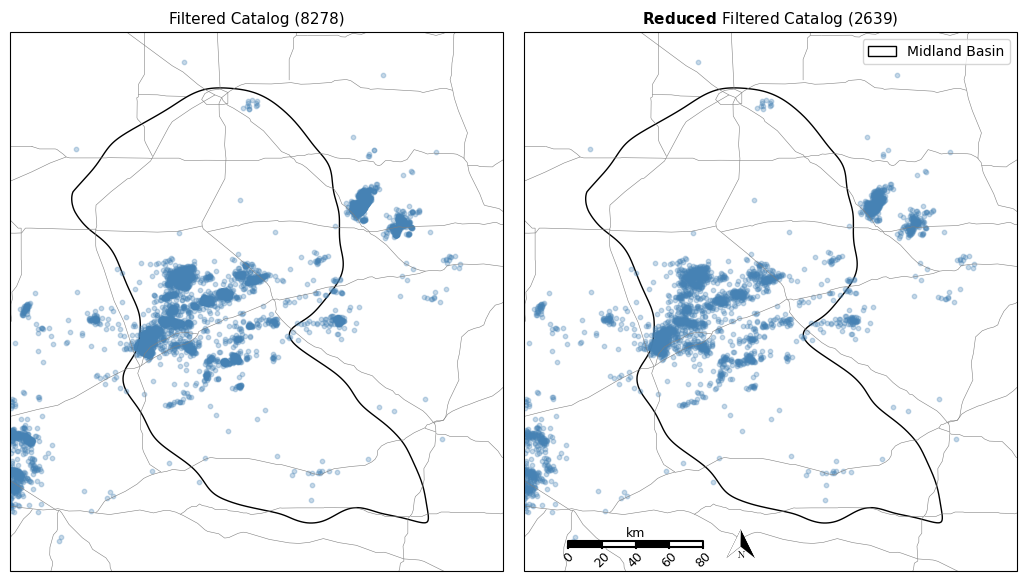

In [11]:
# Midland Basin
LONS = "-103.2,-100"
LATS = "30.5,34"

thr_filter = 111.32*0.01/2
# thr_filter = 0.5
events_df_all = pd.read_csv('texnet_events_rpf.csv') # quality filtered catalog
events_df_filtered = firter_events_df(events_df_all, thr_filter)
# Create a comparison plot between original and filtered datasets
plot_earthquakes_comparison(events_df_all, events_df_filtered, LATS, LONS)

In [12]:
print('Filtered events shape:', events_df_filtered.shape)
print('Original events shape:', events_df_all.shape)

Filtered events shape: (2639, 18)
Original events shape: (8278, 18)


In [13]:
# Store reduced catalog
events_df_filtered.to_csv('texnet_events_rpf_reduced.csv', index=False)